# 06 Hybridizing Models

In this lesson, we'll show how you can modify any architecture to fit any problem, so you can experiment. In our example we will utilize a `UNET` architecture to do:

* Keypoint Regression
* Multi-Label Classificaiton (covered in notebook, not class)
* Classification (covered in notebook, not class)

In [ ]:
#Run once per session
!pip install fastai -q --upgrade

In [ ]:
from fastai.vision.all import *

## Prep Data

In [ ]:
url = "https://drive.google.com/uc?id=1ffJr3NrYPqzutcXsYIVNLXzzUaC9RqYM"
!gdown {url}
from zipfile import ZipFile
with ZipFile('cat-dataset.zip', 'r') as zip_ref:
  zip_ref.extractall()
for i in range(7):
  path = Path(f'CAT_0{i}')
  shutil.rmtree(path)
for i in range(7):
  paths = Path(f'cats/CAT_0{i}').ls()
  for path in paths:
    p = Path(path).absolute()
    par = p.parents[1]
    p.rename(par/p.name)

Downloading...
From: https://drive.google.com/uc?id=1ffJr3NrYPqzutcXsYIVNLXzzUaC9RqYM
To: /content/cat-dataset.zip
4.33GB [01:15, 57.3MB/s]


In [ ]:
path = Path('cats')
lbls = get_files(path, extensions='.cat')
imgs = get_image_files(path)

In [ ]:
def img2kpts(f): return f'{str(f)}.cat'

def sep_points(coords:array):
  "Seperate a set of points to groups"
  kpts = []
  for i in range(1, int(coords[0]*2), 2):
    kpts.append([coords[i], coords[i+1]])
  return tensor(kpts)
  
def get_y(f:Path):
  "Get keypoints for `f` image"
  pts = np.genfromtxt(img2kpts(f))
  return sep_points(pts)

In [ ]:
bad_imgs = []

for name in imgs:
  im = PILImage.create(name)
  y = get_y(name)
  for x in y:
    if x[0] < im.size[0]:
      if x[0] < 0:
        bad_imgs.append(name)
      if x[1] < im.size[1]:
        if x[1] < 0:
          bad_imgs.append(name)
      else:
        bad_imgs.append(name)
    else:
      bad_imgs.append(name)
      
for name in list(set(bad_imgs)):
  name.unlink()

# DataBunch

In [ ]:
def img2kpts(f): return f'{str(f)}.cat'

def sep_points(coords:array):
  "Seperate a set of points to groups"
  kpts = []
  for i in range(1, int(coords[0]*2), 2):
    kpts.append([coords[i], coords[i+1]])
  return tensor(kpts)
  
def get_y(f:Path):
  "Get keypoints for `f` image"
  pts = np.genfromtxt(img2kpts(f))
  return sep_points(pts)

In [ ]:
item_tfms = [Resize(224, method='squish')]
batch_tfms = [Flip(), Rotate(), Zoom(), Warp()]

In [ ]:
dblock = DataBlock(blocks=(ImageBlock, PointBlock),
                   get_items=get_image_files,
                   splitter=RandomSplitter(),
                   get_y=get_y,
                   item_tfms=item_tfms,
                   batch_tfms=batch_tfms)

In [ ]:
bs=16

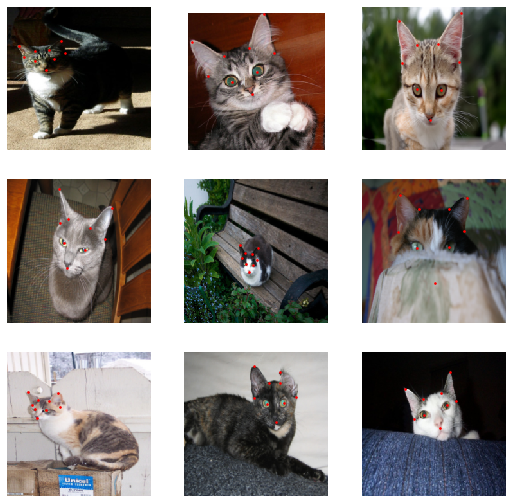

In [ ]:
dls = dblock.dataloaders('', path='', bs=bs)
dls.show_batch()

# Model

Now we need to build our model. First let's look at `unet_learner`'s source code:

In [ ]:
def unet_learner(dls, arch, loss_func=None, pretrained=True, cut=None, splitter=None, config=None, n_in=3, n_out=None,
                 normalize=True, **kwargs):
    "Build a unet learner from `dls` and `arch`"
    if config is None: config = unet_config()
    meta = model_meta.get(arch, _default_meta)
    body = create_body(arch, n_in, pretrained, ifnone(cut, meta['cut']))
    size = dls.one_batch()[0].shape[-2:]
    if n_out is None: n_out = get_c(dls)
    assert n_out, "`n_out` is not defined, and could not be infered from data, set `dls.c` or pass `n_out`"
    if normalize: _add_norm(dls, meta, pretrained)
    model = models.unet.DynamicUnet(body, n_out, size, **config) # HERE
    learn = Learner(dls, model, loss_func=loss_func, splitter=ifnone(splitter, meta['split']), **kwargs)
    if pretrained: learn.freeze()
    return learn

We'll want to mimic how this is being done, specifically in `DynamicUnet`

In [ ]:
from fastai.vision.models.unet import _get_sz_change_idxs, UnetBlock, ResizeToOrig
from fastai.vision.learner import _default_meta, _add_norm

We want to replace the last `ConvLayer` with our custom head (we'll use `create_head`). We need to get the input features, we can do this by taking the last layer's size

In [ ]:
class CustomUnet(SequentialEx):
    "Create a U-Net from a given architecture."
    def __init__(self, encoder, n_classes, img_size, blur=False, blur_final=True, self_attention=False,
                 y_range=None, last_cross=True, bottle=False, act_cls=defaults.activation,
                 init=nn.init.kaiming_normal_, norm_type=None, **kwargs):
        imsize = img_size
        sizes = model_sizes(encoder, size=imsize)
        sz_chg_idxs = list(reversed(_get_sz_change_idxs(sizes)))
        self.sfs = hook_outputs([encoder[i] for i in sz_chg_idxs], detach=False)
        x = dummy_eval(encoder, imsize).detach()

        ni = sizes[-1][1]
        middle_conv = nn.Sequential(ConvLayer(ni, ni*2, act_cls=act_cls, norm_type=norm_type, **kwargs),
                                    ConvLayer(ni*2, ni, act_cls=act_cls, norm_type=norm_type, **kwargs)).eval()
        x = middle_conv(x)
        layers = [encoder, BatchNorm(ni), nn.ReLU(), middle_conv]

        for i,idx in enumerate(sz_chg_idxs):
            not_final = i!=len(sz_chg_idxs)-1
            up_in_c, x_in_c = int(x.shape[1]), int(sizes[idx][1])
            do_blur = blur and (not_final or blur_final)
            sa = self_attention and (i==len(sz_chg_idxs)-3)
            unet_block = UnetBlock(up_in_c, x_in_c, self.sfs[i], final_div=not_final, blur=do_blur, self_attention=sa,
                                   act_cls=act_cls, init=init, norm_type=norm_type, **kwargs).eval()
            layers.append(unet_block)
            x = unet_block(x)

        ni = x.shape[1]
        if imsize != sizes[0][-2:]: layers.append(PixelShuffle_ICNR(ni, act_cls=act_cls, norm_type=norm_type))
        layers.append(ResizeToOrig())
        if last_cross:
            layers.append(MergeLayer(dense=True))
            ni += in_channels(encoder)
            layers.append(ResBlock(1, ni, ni//2 if bottle else ni, act_cls=act_cls, norm_type=norm_type, **kwargs))
        #layers += [ConvLayer(ni, n_classes, ks=1, act_cls=None, norm_type=norm_type, **kwargs)] # HERE
        nf = num_features_model(nn.Sequential(layers[-1])) * (2)
        layers += create_head(nf, n_classes)
        apply_init(nn.Sequential(layers[3], layers[-2]), init)
        if y_range is not None: layers.append(SigmoidRange(*y_range))
        super().__init__(*layers)

    def __del__(self):
        if hasattr(self, "sfs"): self.sfs.remove()

And make a `custom_unet` function to call it

In [ ]:
def custom_unet(dls, arch, loss_func=None, pretrained=True, cut=None, splitter=None, config=None, n_in=3, n_out=None,
                 normalize=True, **kwargs):
    "Build a unet learner from `dls` and `arch`"
    if config is None: config = unet_config()
    meta = model_meta.get(arch, _default_meta)
    body = create_body(arch, n_in, pretrained, ifnone(cut, meta['cut']))
    size = dls.one_batch()[0].shape[-2:]
    if n_out is None: n_out = get_c(dls)
    assert n_out, "`n_out` is not defined, and could not be infered from data, set `dls.c` or pass `n_out`"
    if normalize: _add_norm(dls, meta, pretrained)
    model = CustomUnet(body, n_out, size, **config) # HERE
    learn = Learner(dls, model, loss_func=loss_func, splitter=ifnone(splitter, meta['split']), **kwargs)
    if pretrained: learn.freeze()
    return learn

In [ ]:
learn = custom_unet(dls, resnet34, loss_func=MSELossFlat())

In [ ]:
learn.summary()

CustomUnet (Input shape: ['16 x 3 x 448 x 448'])
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               16 x 64 x 224 x 224  9,408      False     
________________________________________________________________
BatchNorm2d          16 x 64 x 224 x 224  128        True      
________________________________________________________________
ReLU                 16 x 64 x 224 x 224  0          False     
________________________________________________________________
MaxPool2d            16 x 64 x 112 x 112  0          False     
________________________________________________________________
Conv2d               16 x 64 x 112 x 112  36,864     False     
________________________________________________________________
BatchNorm2d          16 x 64 x 112 x 112  128        True      
________________________________________________________________
ReLU                 16 x 64 x 112 x 112  0          False     
_________________________________________________

And now we can train!

(0.0019054606556892395, 1.5848931980144698e-06)

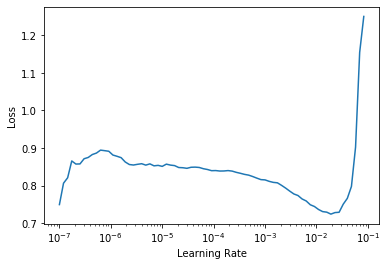

In [ ]:
learn.lr_find()

In [ ]:
learn.fit_one_cycle(3, 1e-3)

epoch,train_loss,valid_loss,time
0,0.119708,0.160717,02:46
1,0.040552,0.019095,02:44
2,0.029885,0.013922,02:45


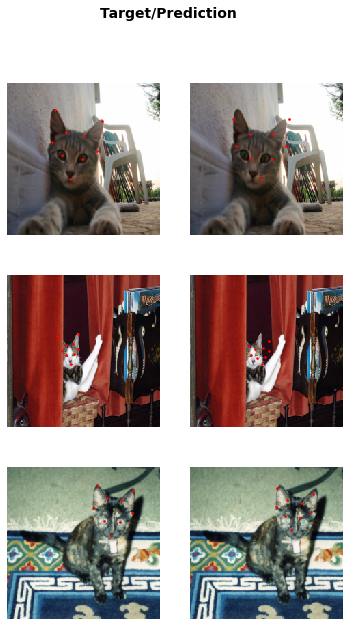

In [ ]:
learn.show_results()

# Other Examples

These are more a proof of concept to practice with, whether the model performs better or worse is unknown

## PETS

In [ ]:
path = untar_data(URLs.PETS)
path = untar_data(URLs.PETS)
fnames = get_image_files(path/'images')
pat = r'(.+)_\d+.jpg$'
batch_tfms = [*aug_transforms(size=224, max_warp=0), Normalize.from_stats(*imagenet_stats)]
item_tfms = RandomResizedCrop(460, min_scale=0.75, ratio=(1.,1.))
bs=18

data = ImageDataLoaders.from_name_re(path, fnames, pat, batch_tfms=batch_tfms, 
                                   item_tfms=item_tfms, bs=bs)

In [ ]:
learn = custom_unet(data, resnet34, loss_func=CrossEntropyLossFlat(), metrics=accuracy)

(0.0015848932787775993, 3.019951861915615e-07)

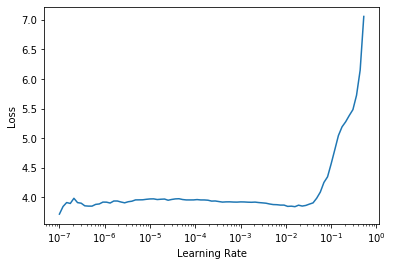

In [ ]:
learn.lr_find()

In [ ]:
learn.fit_one_cycle(5, 1e-3)

epoch,train_loss,valid_loss,accuracy,time
0,2.646517,3.048354,0.147497,02:20
1,1.532955,1.528544,0.517591,02:20
2,1.032563,1.075425,0.650203,02:20
3,0.714636,0.439413,0.864682,02:20
4,0.597098,0.383284,0.893099,02:21


## Planets

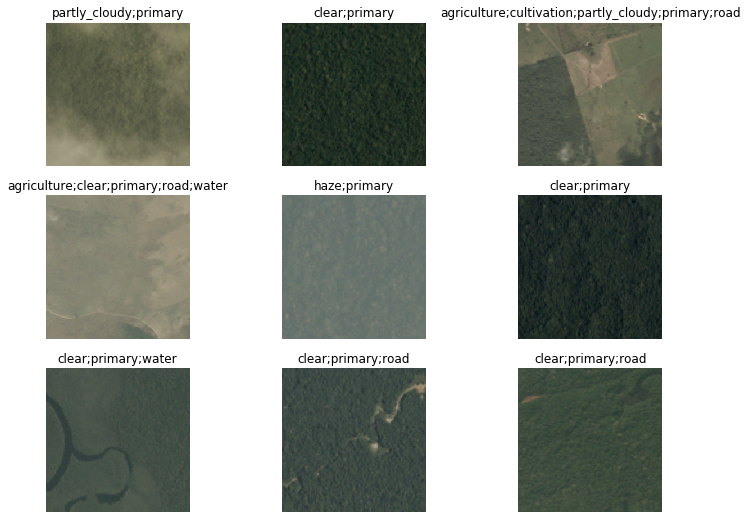

In [ ]:
planet_source = untar_data(URLs.PLANET_SAMPLE)
df = pd.read_csv(planet_source/'labels.csv')
batch_tfms = aug_transforms(flip_vert=True, max_lighting=0.1, max_zoom=1.05, max_warp=0.)
planet = DataBlock(blocks=(ImageBlock, MultiCategoryBlock),
                   get_x=ColReader(0, pref=f'{planet_source}/train/', suff='.jpg'),
                   splitter=RandomSplitter(),
                   get_y=ColReader(1, label_delim=' '),
                   batch_tfms = batch_tfms)
dls = planet.dataloaders(df, bs=12)
dls.show_batch(max_n=9, figsize=(12,9))

In [ ]:
learn = custom_unet(dls, resnet34, loss_func=BCEWithLogitsLossFlat(), metrics=[accuracy_multi])

(0.014454397559165954, 0.03981071710586548)

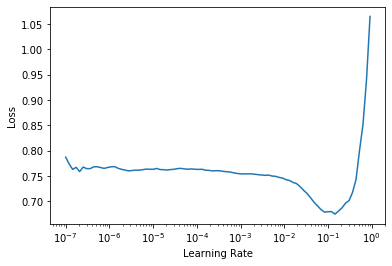

In [ ]:
learn.lr_find()

In [ ]:
learn.fit_one_cycle(5, slice(1e-2))

epoch,train_loss,valid_loss,accuracy_multi,time
0,0.534084,0.344417,0.881765,00:26
1,0.323197,0.270720,0.903235,00:23
2,0.265935,0.274014,0.907059,00:23
3,0.244585,0.207186,0.916177,00:23
4,0.229131,0.204003,0.916471,00:23
